# Import libraries

In [50]:
import time
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import xml.etree.ElementTree as ET

from skimage.transform import resize
from skimage import feature
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split 
from sklearn.metrics import accuracy_score

# I. Build Traffic Sign Classification Model (SVM)

## 1. Read and extract dataset

In [51]:
annotations_dir = 'annotations' 
img_dir = 'images'
img_lst = [] 
label_lst = []
for xml_file in os.listdir(annotations_dir):
    xml_filepath = os.path.join(annotations_dir , xml_file)
    tree = ET.parse(xml_filepath) 
    root = tree.getroot()

    folder = root.find('folder').text
    img_filename = root.find('filename').text 
    img_filepath = os.path.join(img_dir , img_filename) 
    img = cv2.imread(img_filepath)

    for obj in root.findall('object'): 
        classname = obj.find('name').text 
        if classname == 'trafficlight':
            continue
        xmin = int(obj.find('bndbox/xmin').text) 
        ymin = int(obj.find('bndbox/ymin').text)
        xmax = int(obj.find('bndbox/xmax').text) 
        ymax = int(obj.find('bndbox/ymax').text)

        object_img = img[ymin:ymax , xmin:xmax] 
        img_lst.append(object_img) 
        label_lst.append(classname)

In [52]:
print ("Number of obj", len(img_lst))
print ("Class Name", list(set(label_lst)))

Number of obj 1074
Class Name ['speedlimit', 'stop', 'crosswalk']


In [53]:
print ("Image shape:")
print (img_lst[1].shape)

Image shape:
(41, 41, 3)


## 2. Preprocess images

In [54]:
def preprocess_img(img):
    if len(img.shape) > 2:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = img.astype(np.float32)

    resized_img = resize(
        img,
        output_shape=(32, 32), 
        anti_aliasing=True
    )

    hog_feature = feature.hog(
        resized_img,
        orientations = 9,
        pixels_per_cell=(8,8),
        cells_per_block=(2,2),
        transform_sqrt=True,
        block_norm="L2",
        feature_vector=True
    )

    return hog_feature

In [55]:
img_features_lst = []
for img in img_lst:
    hog_feature = preprocess_img(img)
    img_features_lst.append(hog_feature)

img_features = np.array(img_features_lst)
print ("X shape: ")
print (img_features.shape)

X shape: 
(1074, 324)


## 3. Encode label

In [56]:
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(label_lst)

In [57]:
label_encoder.classes_

array(['crosswalk', 'speedlimit', 'stop'], dtype='<U10')

In [58]:
encoded_labels

array([1, 1, 1, ..., 1, 1, 1])

## 4. Split train val set

In [59]:
random_state = 0
test_size = 0.3

X_train, X_val, y_train, y_val = train_test_split(
    img_features, encoded_labels,
    test_size=test_size,
    shuffle=True,
    random_state=random_state
)

## 5. Normalization

In [60]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

In [61]:
X_train

array([[ 0.49120206, -1.420823  , -1.5524764 , ...,  1.4740711 ,
         0.7444558 ,  0.44589344],
       [ 0.2251795 ,  0.39393985, -0.01148725, ..., -0.4106803 ,
        -0.4688078 , -0.42080352],
       [-0.32186475,  1.538133  ,  1.0681365 , ..., -0.14458214,
        -0.52396834,  1.0958284 ],
       ...,
       [-0.5045006 , -0.19742419,  0.40490577, ..., -0.5347415 ,
        -0.5104791 , -0.5319429 ],
       [-0.7032078 ,  1.1544982 ,  1.2276683 , ..., -0.56534225,
        -0.5168479 , -0.41617656],
       [-0.6765122 , -0.52632946,  0.08012083, ..., -0.56534225,
        -0.289816  , -0.60031784]], dtype=float32)

## 6. Training

In [62]:
clf = SVC(kernel='rbf',
          random_state=random_state,
          probability=True,
          C=0.5)

clf.fit(X_train, y_train)

SVC(C=0.5, probability=True, random_state=0)

## 7. Evaluation


In [63]:
y_pred = clf.predict(X_val)
score = accuracy_score(y_pred, y_val)

print ("Evaluation result on val set (accuracy): ")
print(score)

Evaluation result on val set (accuracy): 
0.978328173374613


# II. Traffic Sign Localization (Sliding Window)

## 1. Create sliding window function


In [64]:
def sliding_window(img, window_sizes, stride, scale_factor):
    img_height, img_width = img.shape[:2]
    windows = []
    for window_size in window_sizes:
        window_width, window_height = window_size
        for ymin in range(0, img_height - window_height + 1, stride):
            for xmin in range(0, img_width - window_width + 1, stride):
                xmax = xmin + window_width
                ymax = ymin + window_height

                windows.append([xmin, ymin, xmax, ymax])

    return windows

## 2. Create pyramid image function

In [65]:
def pyramid(img, scale=0.8, min_size=(30, 30)):
    acc_scale = 1.0
    pyramid_imgs = [(img, acc_scale)]

    i = 0
    while True:
        acc_scale = acc_scale * scale
        h = int(img.shape[0] * acc_scale)
        w = int(img.shape[1] * acc_scale)
        if h < min_size[1] or w < min_size[0]:
            break
        img = cv2.resize(img, (w, h))
        pyramid_imgs.append((img, acc_scale * (scale ** i)))
        i += 1

    return pyramid_imgs

## 3. Create bounding box visualization function


In [66]:
def visualize_bbox(img, bboxes, label_encoder):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    for box in bboxes:
        xmin, ymin, xmax, ymax, predict_id, conf_score = box

        cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)

        classname = label_encoder.inverse_transform([predict_id])[0]
        label = f"{classname} {conf_score:.2f}"

        (w, h), _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.6, 1)

        cv2.rectangle(img, (xmin, ymin - 20), (xmin + w, ymin), (0, 255, 0), -1)

        cv2.putText(img, label, (xmin, ymin - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 0), 1)

    plt.imshow(img)
    plt.axis('off')
    plt.show()

In [25]:
img

array([[[ 86,  77,  55],
        [ 89,  80,  60],
        [ 82,  73,  53],
        ...,
        [115, 106,  87],
        [ 92,  83,  63],
        [ 92,  83,  63]],

       [[ 92,  83,  61],
        [ 92,  83,  62],
        [ 90,  81,  60],
        ...,
        [122, 112,  96],
        [ 85,  75,  57],
        [ 77,  67,  49]],

       [[ 95,  88,  63],
        [110, 101,  79],
        [113, 105,  83],
        ...,
        [122, 112, 103],
        [ 81,  72,  58],
        [ 80,  71,  54]],

       ...,

       [[ 98,  89,  66],
        [ 95,  86,  65],
        [ 98,  91,  71],
        ...,
        [107,  97,  86],
        [ 86,  78,  63],
        [ 87,  80,  62]],

       [[ 96,  90,  64],
        [100,  92,  68],
        [100,  94,  70],
        ...,
        [104,  97,  75],
        [ 90,  82,  63],
        [113, 105,  85]],

       [[ 94,  86,  61],
        [100,  93,  67],
        [104,  98,  74],
        ...,
        [107,  99,  74],
        [101,  92,  69],
        [123, 115,  91]]

## 4. Create IoU computing function

In [67]:
def compute_iou(bbox, bboxes, bbox_area, bboxes_area): 
    xxmin = np.maximum(bbox[0], bboxes[:, 0])
    yymin = np.maximum(bbox[1], bboxes[:, 1])
    xxmax = np.minimum(bbox[2], bboxes[:, 2])
    yymax = np.minimum(bbox[3], bboxes[:, 3]) 
    
    w = np.maximum(0, xxmax - xxmin + 1)
    h = np.maximum(0, yymax - yymin + 1) 
    
    intersection = w * h
    iou = intersection / (bbox_area + bboxes_area - intersection) 
    
    return iou

## 5. Create Non-Maximum Suppression function

In [68]:
def nms (bboxes, iou_threshold):
    if not bboxes:
        return []
    scores = np.array([bbox[5] for bbox in bboxes])
    sorted_indices = np.argsort(scores)[::-1]

    xmin = np.array([bbox[0] for bbox in bboxes])
    ymin = np.array([bbox[1] for bbox in bboxes])
    xmax = np.array([bbox[2] for bbox in bboxes])
    ymax = np.array([bbox[3] for bbox in bboxes])

    areas = (xmax - xmin + 1) * (ymax - ymin +1)

    keep = []
    while sorted_indices.size > 0:
        i = sorted_indices[0]
        keep.append(i)

        iou = compute_iou(
            [xmin[i], ymin[i], xmax[i], ymax[i]],
            np.array(
                [
                    xmin[sorted_indices[1:]],
                    ymin[sorted_indices[1:]],
                    xmax[sorted_indices[1:]],
                    ymax[sorted_indices[1:]],
                ]
            ).T,
            areas[i],
            areas[sorted_indices[1:]]
        )

        idx_to_keep = np.where(iou <= iou_threshold)[0]
        sorted_indices = sorted_indices[idx_to_keep + 1]

    return [bboxes[i] for i in keep]

## 6. Inference code

images/road289.png


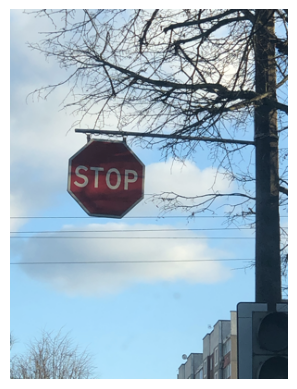

Time process:  3.0033090114593506
images/road504.png


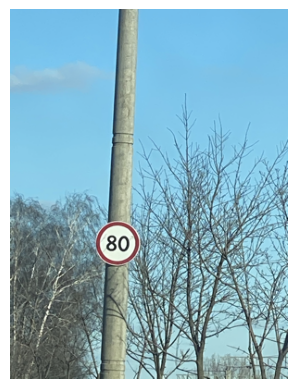

Time process:  3.1944401264190674
images/road262.png


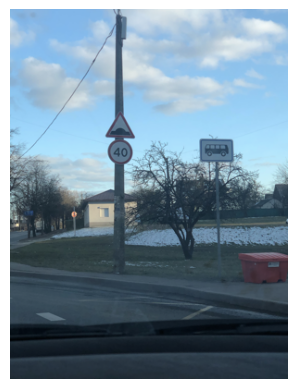

Time process:  2.909109115600586
images/road276.png


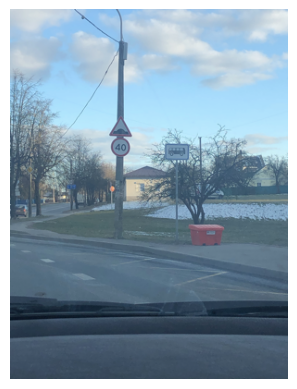

Time process:  2.6675310134887695
images/road510.png


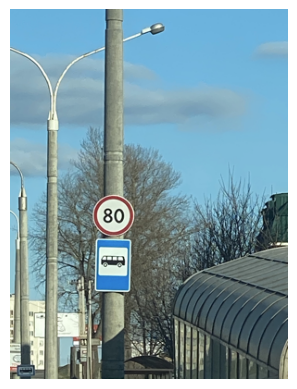

Time process:  2.6266279220581055
images/road538.png


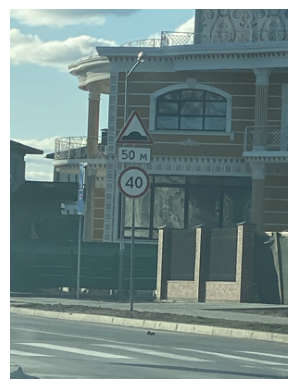

Time process:  2.923923969268799
images/road706.png


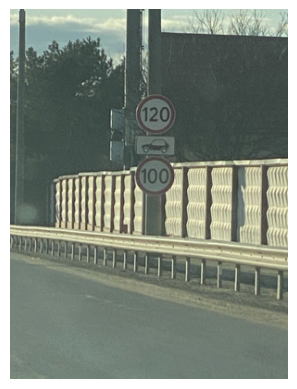

Time process:  2.7892038822174072
images/road712.png


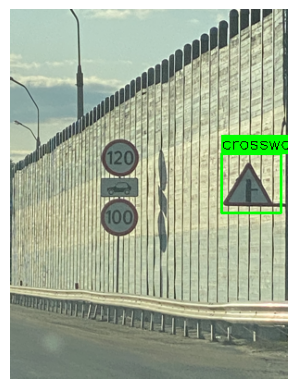

Time process:  2.9614341259002686
images/road869.png


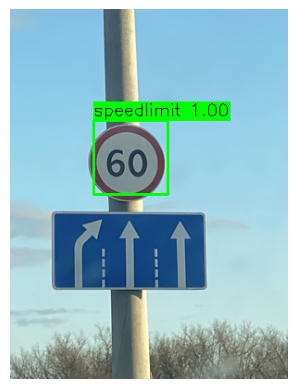

Time process:  2.651370048522949
images/road855.png


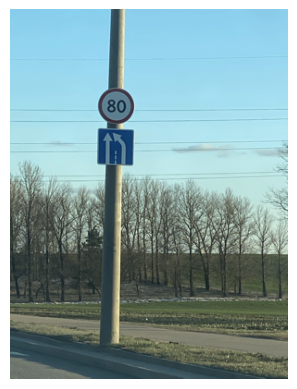

Time process:  2.8118600845336914
images/road699.png


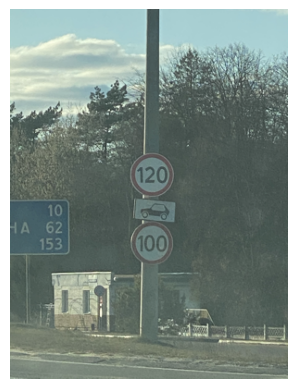

Time process:  2.7365148067474365
images/road841.png


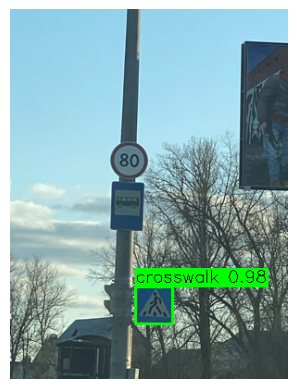

Time process:  2.7467589378356934
images/road114.png


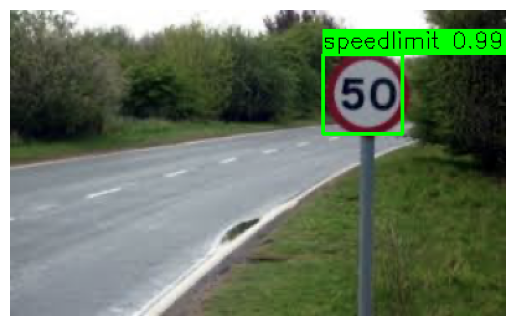

Time process:  2.1724298000335693
images/road30.png


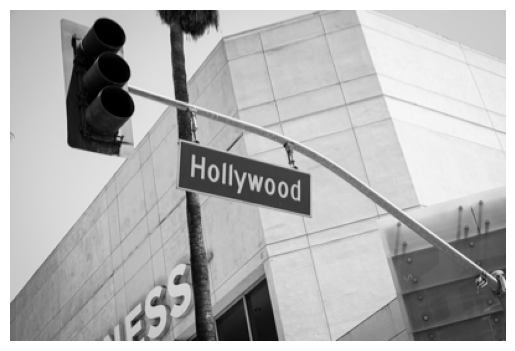

Time process:  2.39465594291687
images/road672.png


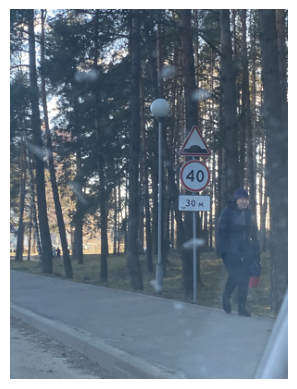

Time process:  2.8034708499908447
images/road24.png


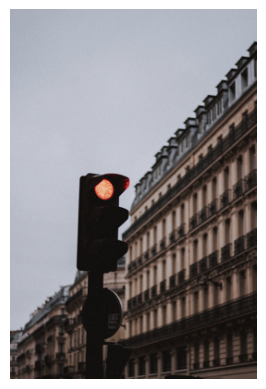

Time process:  2.3827168941497803
images/road666.png


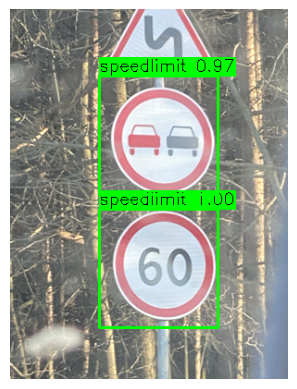

Time process:  2.826362133026123
images/road100.png


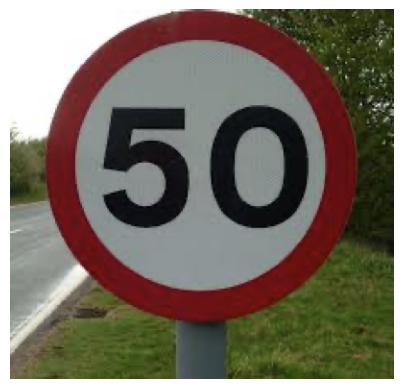

Time process:  3.7991013526916504
images/road128.png


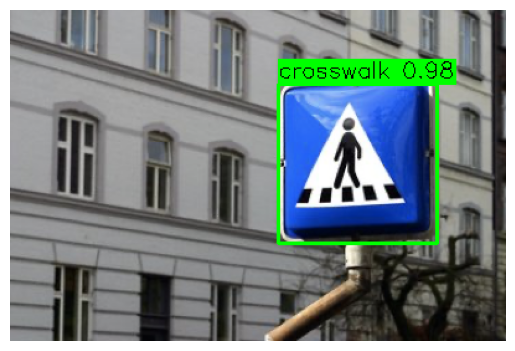

Time process:  2.4208719730377197
images/road18.png


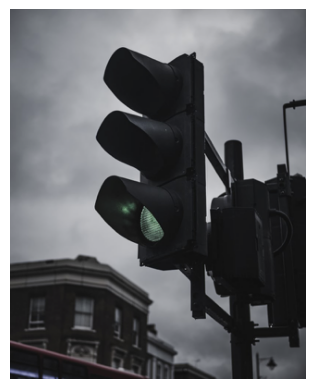

Time process:  3.100893020629883
images/road470.png


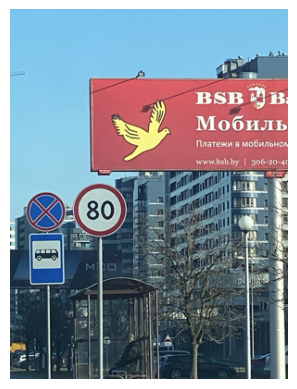

Time process:  2.845323085784912
images/road316.png


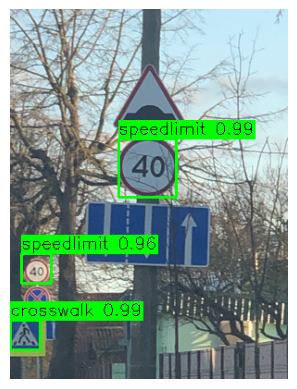

Time process:  2.8451640605926514
images/road302.png


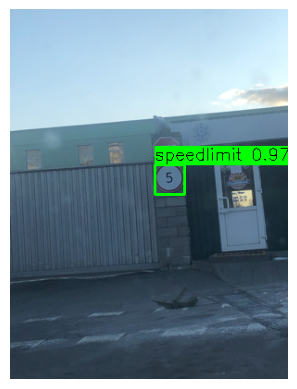

Time process:  2.889159917831421
images/road464.png


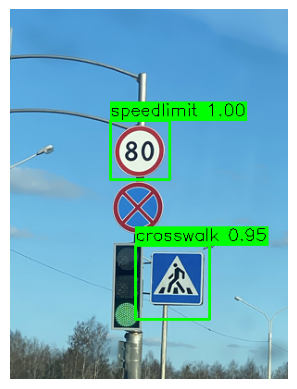

Time process:  2.8095858097076416
images/road458.png


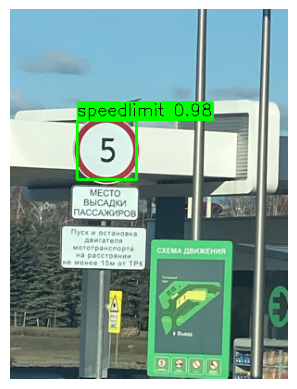

Time process:  2.835878849029541
images/road459.png


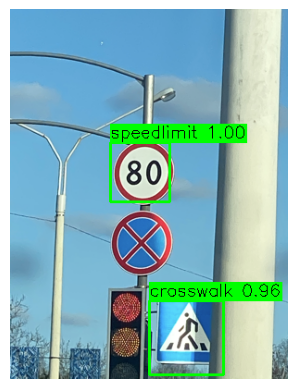

Time process:  2.886017084121704
images/road303.png


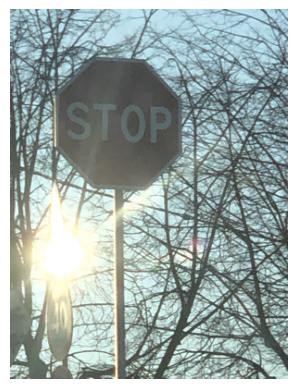

Time process:  2.9916579723358154
images/road465.png


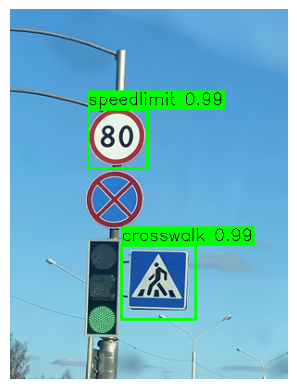

Time process:  2.8386940956115723
images/road471.png


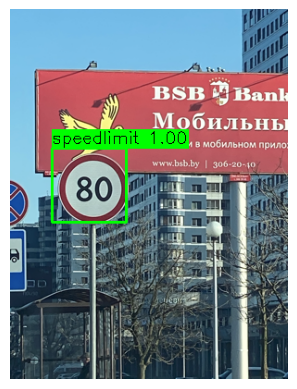

Time process:  2.8624770641326904
images/road317.png


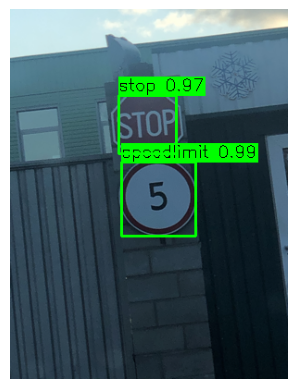

Time process:  2.915152072906494
images/road19.png


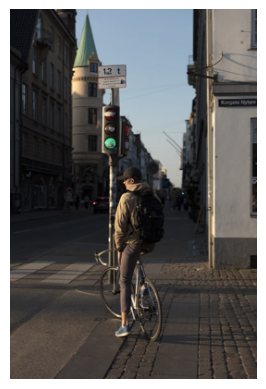

Time process:  2.395625114440918
images/road129.png


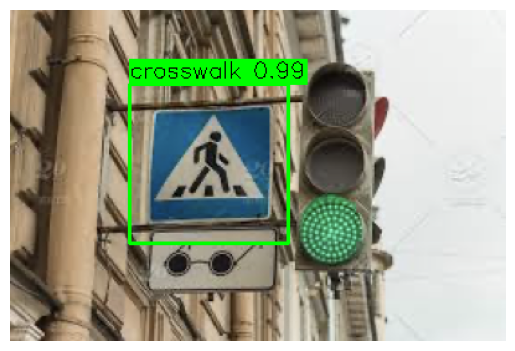

Time process:  2.4632022380828857
images/road667.png


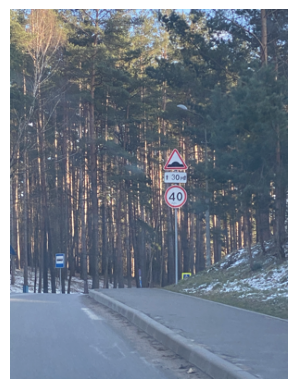

Time process:  2.907917022705078
images/road25.png


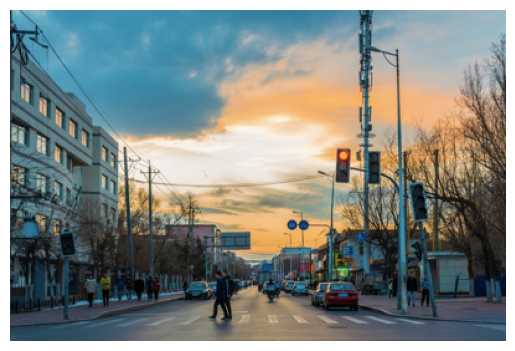

Time process:  2.562662124633789
images/road101.png


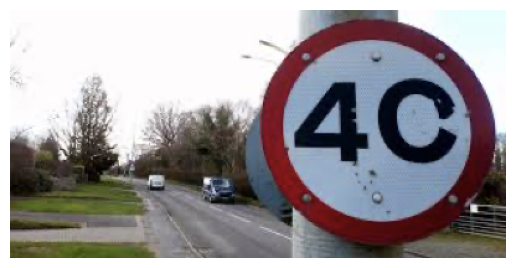

Time process:  1.7598986625671387
images/road115.png


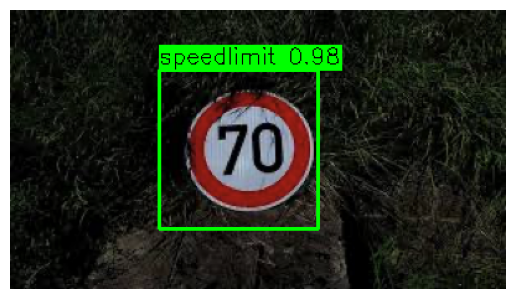

Time process:  2.048785924911499
images/road673.png


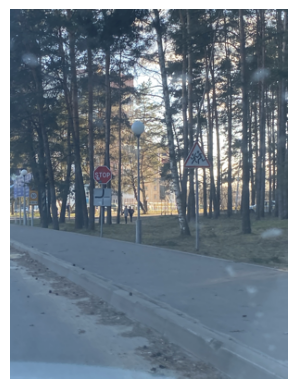

Time process:  2.9281249046325684
images/road31.png


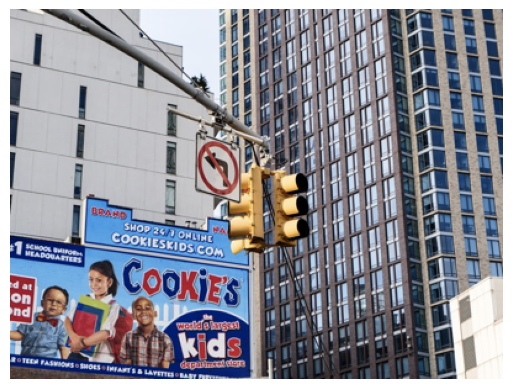

Time process:  2.982332944869995
images/road840.png


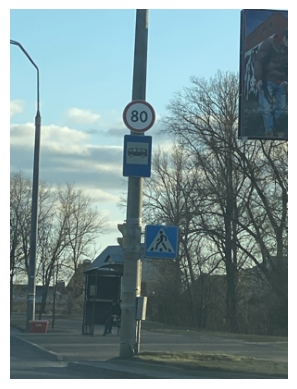

Time process:  2.815603017807007
images/road698.png


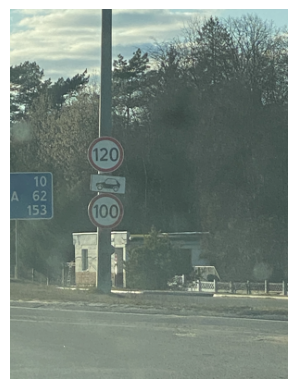

Time process:  2.7558231353759766


In [71]:
import time

img_dir = 'images'
img_filename_lst = os.listdir(img_dir)[:40]
conf_threshold = 0.95
iou_threshold = 0.1
stride = 12
window_sizes = [
    (32, 32),
    (64, 64),
    (128, 128)
]

for img_filename in img_filename_lst:
    start_time = time.time()
    img_filepath = os.path.join(img_dir, img_filename)
    print(img_filepath)
    bboxes = []
    img = cv2.imread(img_filepath)
    pyramid_imgs = pyramid(img)

    for pyramid_img_info in pyramid_imgs:
        pyramid_img, scale_factor = pyramid_img_info
        window_lst = sliding_window(
            pyramid_img,
            window_sizes=window_sizes,
            stride=stride,
            scale_factor=scale_factor
        )
        for window in window_lst:
            xmin, ymin, xmax, ymax = window
            object_img = pyramid_img[ymin:ymax, xmin:xmax]
            preprocessed_img = preprocess_img(object_img)
            normalized_img = scaler.transform([preprocessed_img])[0]
            decision = clf.predict_proba([normalized_img])[0]
            if np.all(decision < conf_threshold):
                continue
            else:
                predict_id = np.argmax(decision)
                conf_score = decision[predict_id]
                xmin = int(xmin / scale_factor)
                ymin = int(ymin / scale_factor)
                xmax = int(xmax / scale_factor)
                ymax = int(ymax / scale_factor)
                bboxes.append(
                    [xmin, ymin, xmax, ymax, predict_id, conf_score]
                )
    bboxes = nms(bboxes, iou_threshold)
    visualize_bbox(img, bboxes, label_encoder)

    print('Time process: ', time.time() - start_time)

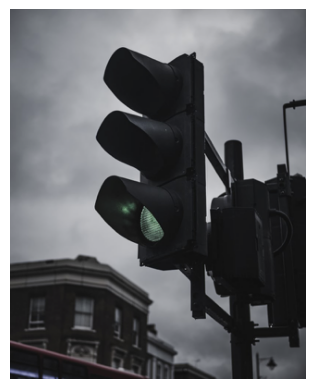

Time process:  132.79284405708313
